#### Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-06-30 по 2023-07-06 включительно. Для эксперимента были задействованы 2 и 1 группы. В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [1]:
import pandas as pd
import numpy as np
import pandahouse
from scipy.stats import ttest_ind, mannwhitneyu, poisson

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [2]:
# параметры подключения
# наверное, их стоило удалить?..
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230720'
}

In [3]:
# для оптимизации заранее посчитаем стр для каждого пользователя
q = """
    SELECT
        user_id,
        exp_group,
        SUM(action='like') AS like,
        SUM(action='view') AS view,
        like / view AS ctr
    FROM simulator_20230720.feed_actions 
    WHERE time::DATE BETWEEN '2023-06-30' AND '2023-07-06'
        AND exp_group IN (1, 2)
    GROUP BY user_id, exp_group
"""

# продолжим работу с пандасом
df = pandahouse.read_clickhouse(q, connection=connection)
df.head()

,user_id,exp_group,like,view,ctr
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [4]:
# разделим сразу датасет по группам
control = df[df['exp_group'] == 1]
test = df[df['exp_group'] == 2]

# проверим размерность
print('Размер контрольной группы:', control.shape[0])
print('Размер тестовой группы:', test.shape[0])

Размер контрольной группы: 10020
Размер тестовой группы: 9877


In [5]:
# для визуализации изменим название групп
df['exp_group'] = df['exp_group'].apply(lambda x: 'control' if x==1 else 'test' )

Размеры контрольной и тестовой группы примерно одинаковые.

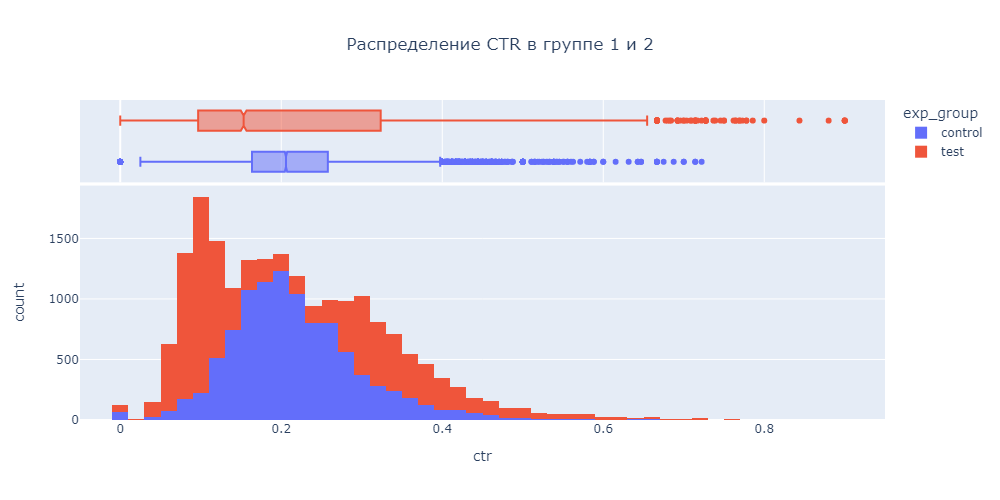

In [6]:
# построим гистограмму распределения ctr в разрезе групп
ctr_hist = px.histogram(
    data_frame=df,
    x='ctr',
    color='exp_group',
    marginal='box',
    width=1000,
    nbins=50,
    title='Распределение CTR в группе 1 и 2'
)

# добавим немного наглядности и выведем график
ctr_hist.update_layout(title=dict(x=.5, xanchor='center'))
ctr_hist.show('png')

Распределение в контрольной группе близко к нормальному, в то время как в тестовой группе нормальным его можно назвать уж совсем условно. Медианное (и, скорее всего, среднее тоже) значение заметно больше, чем в тестовой группе, а также имеет явно менее широкое распределение.  
Кажется результат уже сейчас довольно очевиден, тестовая группа явно превалирует у значений близких к нулю, имеет меньшую медиану.
Но, стоит обратить внимание, что у количество пользователей с CTR > 0.3 в тестовой группе явно больше, что может быть связано с, например, полом, страной, типом ОС и тд.

### <center> **t-критерий Стьюдента**

In [7]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в контрольной и тестовой группе не равны.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['ctr'], test['ctr'], equal_var=False, alternative='two-sided')

print('p-value: ', round(p_value, 4))

if p_value < alpha:
    print('Принимаем альтернативную гипотезу. ', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  0.6854
Принимаем нулевую гипотезу. Среднее значение CTR в обеих группах равны.


Ага... Так может, надо было просто сравнить средние значения в двух группах?...

In [8]:
print('Средний CTR контрольной группы:', round(control['ctr'].mean(), 4))
print('Средний CTR тестовой группы:', round(test['ctr'].mean(), 4))

Средний CTR контрольной группы: 0.2168
Средний CTR тестовой группы: 0.2161


Откровенно, никакой полезной информации нам это так и не дало. То есть да, среднее значение в обеих группах совпадает, а зачем тогда выдумывать велосипед и тратиться ресурсами на введение новой системы? С другой стороны, как будто бы в каких-то случаях CTR все таки может увеличиваться при введении новой системы рекомендации. Попробуем с этим разобраться чуть позже, а сейчас проведем еще несколько тестов.

### <center> **t-тест на сглаженном CTR**

In [9]:
def get_smothed_ctr(likes, view, global_ctr, alpha):
    """Функция для сглаживания CTR"""
    
    smothed_ctr = (likes + alpha*global_ctr) / (view + alpha)
    
    return smothed_ctr

In [10]:
# посчитаем общий ctr в каждой группе
global_ctr_control = control['like'].sum() / control['view'].sum()
global_ctr_test = test['like'].sum() / test['view'].sum()

In [11]:
control['smothed_ctr'] = control.apply(lambda x: get_smothed_ctr(x['like'], x['view'], global_ctr_control, 5), axis=1)
test['smothed_ctr'] = test.apply(lambda x: get_smothed_ctr(x['like'], x['view'], global_ctr_control, 5), axis=1)

C:\Users\volod\AppData\Local\Temp\ipykernel_24556\3832311458.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\volod\AppData\Local\Temp\ipykernel_24556\3832311458.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# определяем гипотезы
Ho = 'Среднее значение CTR в обеих группах равны.'
Ha = 'Среднее значение CTR в контрольной и тестовой группе не равны.'

# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = ttest_ind(control['smothed_ctr'], test['smothed_ctr'], equal_var=False, alternative='two-sided')

print('p-value: ', round(p_value, 4))

if p_value < alpha:
    print('Принимаем альтернативную гипотезу. ', Ha)
else:
    print('Принимаем нулевую гипотезу.', Ho)

p-value:  0.2133
Принимаем нулевую гипотезу. Среднее значение CTR в обеих группах равны.


Попробуем посмотреть повнимательнее на распределениен сглаженного CTR.

c:\Users\volod\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



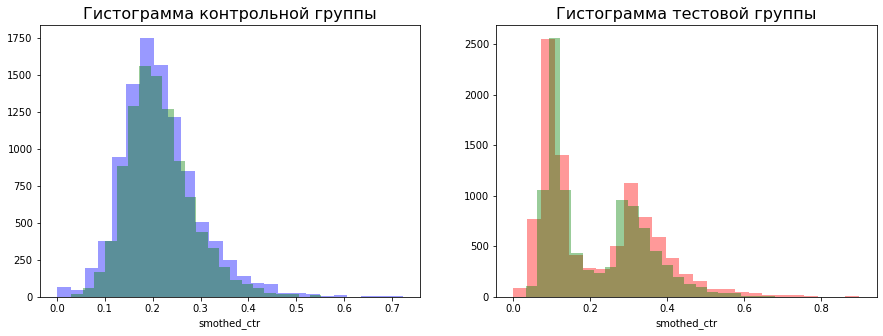

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
sns.distplot(control.ctr, kde = False, bins=25, ax=axes[0], color='blue')
sns.distplot(control.smothed_ctr, kde = False, bins=25, ax=axes[0], color='green');
axes[0].set_title('Гистограмма контрольной группы', fontsize=16)

sns.distplot(test.ctr, kde = False, bins=25, ax=axes[1], color='red')
sns.distplot(test.smothed_ctr, kde = False, bins=25, ax=axes[1], color='green')
axes[1].set_title('Гистограмма тестовой группы', fontsize=16);

Результаты ровно никак не поменялись, хотя и значение p-value сильно снизилось. В целом это было довольно ожидаемо, поскольку график тестовой группы у нас был сильно разрежен, поскольку является двугорбым. Возможно, стоило попробовать увеличить сглаживание, однако это бы могло привести и к искажению результатов.

### <center> **Тест Манна-Уитни**

In [14]:
# укажем уровень значимости
alpha = 0.05

# посчитаем p-value
stat, p_value = mannwhitneyu(control['ctr'], test['ctr'])

print('p-value: ', round(p_value, 4))

if p_value < alpha:
    print('Принимаем альтернативную гипотезу.')
else:
    print('Принимаем нулевую гипотезу.')

p-value:  0.0
Принимаем альтернативную гипотезу.


Тест Мана-Уитни говорит нам, что P(Control > Test) != P(Test > Control). 
Если по-русски, то вероятность того, что случайное значение из контроля больше случайного значения из теста не равна обратной ситуации.
Давайте проверим это.

In [15]:
C_vs_T = 0
for _ in range(10000):
    C_vs_T += control['ctr'].sample().values[0] > test['ctr'].sample().values[0]
    
print('В', C_vs_T/100, '% случаев Контроль > Теста.')

В 55.99 % случаев Контроль > Теста.


Исходя из результатов данного теста, CTR тестовой группы в примерно 55% случаев будет меньше, чем у контрольной группы. Переводя на русский язык, выходит, что использование предложенной системы рекомендации для всех пользователей является, как минимум, не оптимальным.

### <center> **Пуассоновский бутстреп для подсчета разницы в CTR**

In [16]:
def bootstrap(like1, view1, like2, view2, n_bootstrap=2000):
    """ 1. из распределения Пуассона генерируем «сколько раз этот пользователь попал в псевдовыборку» - «вес» пользователя
        2. считаем "глобальный CTR"
        3. считаем разницу между обеими группами и повторяем процедуру 2000 раз
    """
    
    # считаем веса в обеих группах
    control_weigth = poisson(1).rvs(
        (n_bootstrap, len(like1))
        ).astype(np.int64)

    test_weigth = poisson(1).rvs(
        (n_bootstrap, len(like2))
        ).astype(np.int64)
    
    # считаем глобальный стр
    control_ctr = (control_weigth * like1).sum(axis=1) / (control_weigth * view1).sum(axis=1)
    test_ctr = (test_weigth * like2).sum(axis=1) / (test_weigth * view2).sum(axis=1)

    return control_ctr, test_ctr

In [17]:
# переводим для рассчетов в массивы
control_like = df[df['exp_group'] == 'control'].like.to_numpy()
control_view = df[df['exp_group'] == 'control'].view.to_numpy()
test_like = df[df['exp_group'] == 'test'].like.to_numpy()
test_view = df[df['exp_group'] == 'test'].view.to_numpy()

# считаем значения ctr
control_ctr, test_ctr = bootstrap(control_like, control_view, test_like, test_view)

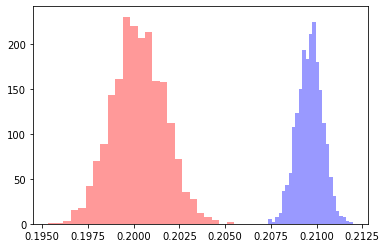

In [18]:
control_ctr = pd.Series(control_ctr)
test_ctr = pd.Series(test_ctr)

# визуализируем результат
sns.distplot(control_ctr, kde = False, bins=25, color='blue')
sns.distplot(test_ctr, kde = False, bins=25, color='red');

Наши выборки теперь практически не пересекаются, т.е. значения CTR контрольной группы заметно "правее" тестовой группы. 

### <center> **Выводы** 
Объективно, с учетом проведенных исследований, введение рекомендательной системы, используемой на группе 2, для всех пользователей является неоправданным. Возможно, данная рекомендательная система покажет результат на какой-то более узкой группе, например, для конкретной страны/пола/возраста/типа ОС, однако это требует дополнительного исследования. Например, в тестовой группе у пользователей из Украины "на глаз" CTR в тестовой группе заметно смещался вправо. Однако любую гипотезу необходимо исследовать.

Такая ситуация могла возкинуть по целому ряду причин:  
**1.** Новая рекомендательная система могла быть неудобна или неактуальна для пользователей.  
**2.** Новая рекомендательная система может требовать доработки, например, у нас нет данных о ее работоспособности, актуальности, наличии ошибок и тд  
**3.** Недостаточное время и/или количество человек для проведения A/B-тестирования. У нас нет данных о том кто, как и каким образом определил такие сроки и такую выборку для данного теста, мы никак не проверяли кумулятивные показатели, не проверили стабилизировались ли данные для дальнейшего анализа, поэтому сложно считать полученные результаты достоверными. Возможно, данная рекомендательная система показала бы сильно лучшие результаты в случае проведения более длительного срока тестирования.  